In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.applications import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam



In [2]:
#configuring gpu memory usage

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set a memory limit for the first GPU (assuming at least one GPU is available)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Limit to 4GB
        
        # After setting the configuration, list logical GPUs to verify the configuration
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        # Print information about the available GPUs and logical GPUs
        print(len(gpus), "Physical GPU(s) available,", len(logical_gpus), "Logical GPU(s) configured.")
        
    except RuntimeError as e:
        # Print any runtime error that occurs during configuration
        print("Error:", e)
else:
    print("No GPU(s) available. TensorFlow cannot use GPU acceleration.")


1 Physical GPU(s) available, 1 Logical GPU(s) configured.


In [3]:
# helper function for plotting model history
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Reading and preparing data for model training, Using ImageDataGenrator from tensorflow to use image augmentations for training. 

In [4]:
df = pd.read_csv("../balanced_data.csv")
df['cancer'] = df['cancer'].astype(str)


In [5]:
train_df, val_df = train_test_split(df, test_size=0.08, random_state=101)

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_FOLDER = '../Dataset2'

In [6]:
#setting up the training and validation datagenerator objects.

train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True       
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_FOLDER,                 
    x_col='image_name',                      
    y_col='cancer',                       
    target_size=IMAGE_SIZE,                
    batch_size=16,
    class_mode='binary'                   
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=INPUT_FOLDER,
    x_col='image_name',
    y_col='cancer',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 2130 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.


## Model training and evalutation metrics.

In [8]:
base_model = ResNet50V2(weights='imagenet',input_shape=(256,256,3),include_top=False)

for layer in base_model.layers:
    layer.trainable = False

In [9]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2)) 
model.add(Dense(1,activation='sigmoid'))

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,loss=['binary_crossentropy'],metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 524,801
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
model_history = model.fit(train_generator,epochs=50,validation_data=val_generator,steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 12s 137ms/step - loss: 0.8216 - accuracy: 0.5063 - val_loss: 0.7080 - val_accuracy: 0.4946
Epoch 2/50
50/50 [==============================] - 6s 129ms/step - loss: 0.7052 - accuracy: 0.5475 - val_loss: 0.6959 - val_accuracy: 0.5376
Epoch 3/50
50/50 [==============================] - 6s 127ms/step - loss: 0.6851 - accuracy: 0.5636 - val_loss: 0.7101 - val_accuracy: 0.4946
Epoch 4/50
50/50 [==============================] - 6s 126ms/step - loss: 0.6960 - accuracy: 0.5649 - val_loss: 0.6898 - val_accuracy: 0.5108
Epoch 5/50
50/50 [==============================] - 6s 127ms/step - loss: 0.6851 - accuracy: 0.5433 - val_loss: 0.6921 - val_accuracy: 0.5484
Epoch 6/50
50/50 [==============================] - 6s 128ms/step - loss: 0.6644 - accuracy: 0.6025 - val_loss: 0.6957 - val_accuracy: 0.5699
Epoch 7/50
50/50 [==============================] - 6s 127ms/step - loss: 0.6725 - accuracy: 0.5800 - val_loss: 0.7543 - val_accuracy: 0.5000
Epoch

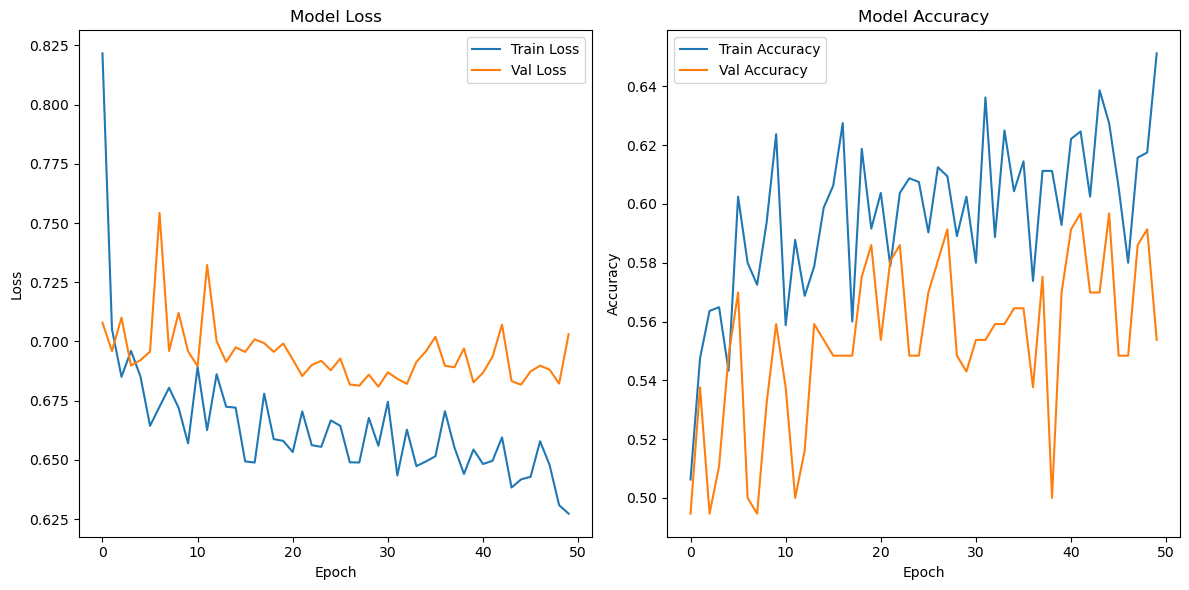

In [12]:
plot_training_history(model_history)

In [13]:
preds_a = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

12/12 [==============================] - 1s 50ms/step


In [14]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))

12/12 [==============================] - 1s 32ms/step - loss: 0.7031 - accuracy: 0.5538


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

In [16]:
class_names = val_generator.class_indices.keys()
report = classification_report(y_true, preds_a, target_names=class_names)

In [17]:
print(report)

              precision    recall  f1-score   support

           0       0.69      0.40      0.51        94
           1       0.57      0.82      0.67        92

    accuracy                           0.61       186
   macro avg       0.63      0.61      0.59       186
weighted avg       0.63      0.61      0.59       186



In [18]:
print(confusion_matrix(y_true, preds_a))

[[38 56]
 [17 75]]


In [19]:
model.save("resnet50v2_9280.h5")